# Préparation de la base de données #

On importe les packages qui seront nécessaires pour notre analyse de données. 

In [63]:
!pip install pathlib2
!pip install python-Levenshtein
!pip install openpyxl
!pip install --upgrade xlrd
!pip install pandas fiona shapely pyproj rtree
!pip install pyreadr

import requests
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pyreadr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

## Préparation Préliminaire sur R ##

In [ ]:
#Code sur R pour convertir les parties de la base de données qui nous intéressait en fichier csv
"""
#Spécification du chemin

chemin_csv <- "W:/Documents/3A/SocioQ/movie.csv"

# Exporter la base de données en format CSV
write.csv(movies, file = chemin_csv, row.names = FALSE)
"""

## Importation sur Python et création de la base de données d'intérêt ##

On importe la base de donnée qui nous intéresse. Il s'agit de celle convertie précédemment.

In [41]:
encodage = 'latin-1' #Adaptation de l'encodage
try:
    movie = pd.read_csv('movie.csv', encoding=encodage, sep=',')
except pd.errors.ParserError as e:
    print(f"Error reading CSV file: {e}")

/tmp/ipykernel_262/1916420045.py:3: DtypeWarning: Columns (24,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  movie = pd.read_csv('movie.csv', encoding=encodage, sep=',')


On va supprimer les colonnes pas intéressantes dans le cadre de notre analyse pour faciliter l'implémentation. 

In [46]:
df = movie[['url', 'id', 'note_Presse', 'note_Spectateurs', 'Box Office France','Année de production', 'Distributeur','Budget','Langues', 'Récompense']]
df

,url,id,note_Presse,note_Spectateurs,Box Office France,Année de production,Distributeur,Budget,Langues,Récompense
0,https://www.allocine.fr/film/fichefilm_gen_cfi...,304685,"4,0","3,9",879 339 entrées,2023.0,Gaumont Distribution,-,Français,NaN
1,https://www.allocine.fr/film/fichefilm_gen_cfi...,255726,"4,9","4,3",866 227 entrées,2022.0,Universal Pictures International France,-,Anglais,NaN
2,https://www.allocine.fr/film/fichefilm_gen_cfi...,287538,"3,5","3,9",394 717 entrées,2023.0,SND,-,Français,NaN
3,https://www.allocine.fr/film/fichefilm_gen_cfi...,277129,"2,7","3,7",2 122 973 entrées,2023.0,Warner Bros. France,-,Anglais,NaN
4,https://www.allocine.fr/film/fichefilm_gen_cfi...,289056,"3,2","4,1",161 254 entrées,2022.0,ARP Sélection,-,Anglais,NaN
...,...,...,...,...,...,...,...,...,...,...
102905,https://www.allocine.fr/film/fichefilm_gen_cfi...,261493,NaN,NaN,NaN,2018.0,-,-,Anglais,NaN
102906,https://www.allocine.fr/film/fichefilm_gen_cfi...,261515,NaN,NaN,NaN,2013.0,-,-,Japonais,NaN
102907,https://www.allocine.fr/film/fichefilm_gen_cfi...,313983,NaN,NaN,NaN,2023.0,-,-,Anglais,NaN
102908,https://www.allocine.fr/film/fichefilm_gen_cfi...,314869,NaN,NaN,NaN,2024.0,-,-,Anglais,NaN


In [47]:
# Remplacement de certains caractères pour faciliter le traitement des données
df['note_Presse'] = pd.to_numeric(df['note_Presse'].replace('--', pd.NA).str.replace(',', '.'), errors='coerce')
df['note_Spectateurs'] = pd.to_numeric(df['note_Spectateurs'].replace('--', pd.NA).str.replace(',', '.'), errors='coerce')

/tmp/ipykernel_262/338836235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['note_Presse'] = pd.to_numeric(df['note_Presse'].replace('--', pd.NA).str.replace(',', '.'), errors='coerce')
/tmp/ipykernel_262/338836235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['note_Spectateurs'] = pd.to_numeric(df['note_Spectateurs'].replace('--', pd.NA).str.replace(',', '.'), errors='coerce')


In [14]:
df_sans_nan = df.dropna(subset=['note_Presse', 'note_Spectateurs']) #On vire les NaN pour computer la régression

In [15]:
df_sans_nan['Récompense'] = df_sans_nan['Récompense'].notna().astype(int) #Variable binaire pour signifier que le film a été récompensé (variable de contrôle) 

/tmp/ipykernel_262/507900940.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sans_nan['Récompense'] = df_sans_nan['Récompense'].notna().astype(int) #Variable binaire pour signifier que le film a été récompensé


In [16]:
df = df_sans_nan

# Traitement des données #

## Statistiques Descriptives ##

In [54]:
#Génération d'un tableau de statistiques descriptives 
df.describe()

,id,note_Presse,note_Spectateurs,Année de production,Récompense
count,12647.000000,12647.000000,12647.000000,12643.000000,12647.000000
mean,143700.874753,3.189215,3.040650,2006.453136,0.148652
std,95849.176545,0.718512,0.684756,14.775440,0.355759
min,4.000000,1.000000,0.800000,1921.000000,0.000000
25%,47214.500000,2.700000,2.600000,2002.000000,0.000000
50%,138489.000000,3.200000,3.100000,2009.000000,0.000000
75%,232057.500000,3.600000,3.600000,2016.000000,0.000000
max,311575.000000,5.000000,4.600000,2023.000000,1.000000


### Création de catégories ###

In [10]:
#Création de catégories de notes pour un histogramme 

def categorie_note(colonne): 
    #On définit des conditions 
    conditions = [
        (df[str(colonne)] >= 0.0) & (df[str(colonne)]< 0.5),
        (df[str(colonne)] >= 0.5) & (df[str(colonne)] < 1.5),
        (df[str(colonne)]  >= 1.5) & (df[str(colonne)] < 2.5),
        (df[str(colonne)]  >= 2.5) & (df[str(colonne)] < 3.5),
        (df[str(colonne)] >= 3.5) & (df[str(colonne)] < 4.5),
        (df[str(colonne)] >= 4.5)
    ]
    # Définition des catégories correspondantes
    categories = [0, 1, 2, 3, 4, 5]

    # Création de la colonne catégorielle 
    df['Category_' + str(colonne)] = pd.cut(df[str(colonne)], bins=[0, 0.5, 1.5, 2.5, 3.5, 4.5, float('inf')], labels=categories, right=False)
    return df

categorie_note('note_Presse')
categorie_note('note_Spectateurs')

/tmp/ipykernel_238/1731919364.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Category_' + str(colonne)] = pd.cut(df[str(colonne)], bins=[0, 0.5, 1.5, 2.5, 3.5, 4.5, float('inf')], labels=categories, right=False)
/tmp/ipykernel_238/1731919364.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Category_' + str(colonne)] = pd.cut(df[str(colonne)], bins=[0, 0.5, 1.5, 2.5, 3.5, 4.5, float('inf')], labels=categories, right=False)


,url,id,note_Presse,note_Spectateurs,Année de production,Distributeur,Budget,Langues,Récompense,Category_note_Presse,Category_note_Spectateurs
0,https://www.allocine.fr/film/fichefilm_gen_cfi...,304685,4.0,3.9,2023.0,Gaumont Distribution,-,Français,0,4,4
1,https://www.allocine.fr/film/fichefilm_gen_cfi...,255726,4.9,4.3,2022.0,Universal Pictures International France,-,Anglais,0,5,4
2,https://www.allocine.fr/film/fichefilm_gen_cfi...,287538,3.5,3.9,2023.0,SND,-,Français,0,4,4
3,https://www.allocine.fr/film/fichefilm_gen_cfi...,277129,2.7,3.7,2023.0,Warner Bros. France,-,Anglais,0,3,4
4,https://www.allocine.fr/film/fichefilm_gen_cfi...,289056,3.2,4.1,2022.0,ARP Sélection,-,Anglais,0,3,4
...,...,...,...,...,...,...,...,...,...,...,...
86540,https://www.allocine.fr/film/fichefilm_gen_cfi...,53380,3.3,3.0,2003.0,Swift Distribution,-,-,0,3,3
87509,https://www.allocine.fr/film/fichefilm_gen_cfi...,8791,3.2,3.0,1996.0,-,-,-,0,3,3
93873,https://www.allocine.fr/film/fichefilm_gen_cfi...,23127,2.4,2.7,1998.0,-,-,-,0,2,3
97227,https://www.allocine.fr/film/fichefilm_gen_cfi...,11357,2.6,3.0,1998.0,-,-,-,0,3,3


### Graphique ### 

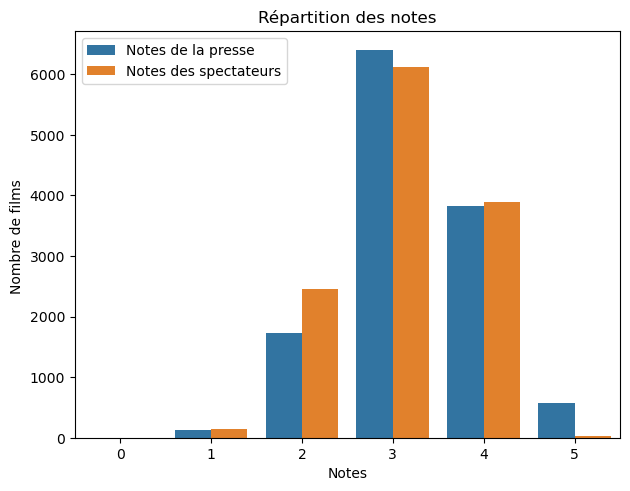

In [67]:
# On combine les catégories
melted_df = pd.melt(df, value_vars=['Category_note_Presse', 'Category_note_Spectateurs'])

# Création d'un graphique
ax = sns.countplot(x='value', hue='variable', data=melted_df)

# Ajout de la légende avec des labels personnalisés
ax.legend(labels=['Notes de la presse', 'Notes des spectateurs'])
plt.tight_layout()
plt.ylabel('Nombre de films ')
plt.xlabel("Notes")
plt.title('Répartition des notes')

#Exportation 
plt.savefig('GraphNotes.png')

# Affichage
plt.show()

## Régressions linéaires ##

                            OLS Regression Results                            
Dep. Variable:       note_Spectateurs   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     4992.
Date:                Fri, 08 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:22:47   Log-Likelihood:                -8477.7
No. Observations:               10117   AIC:                         1.696e+04
Df Residuals:                   10115   BIC:                         1.697e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2913      0.025     50.924      0.0

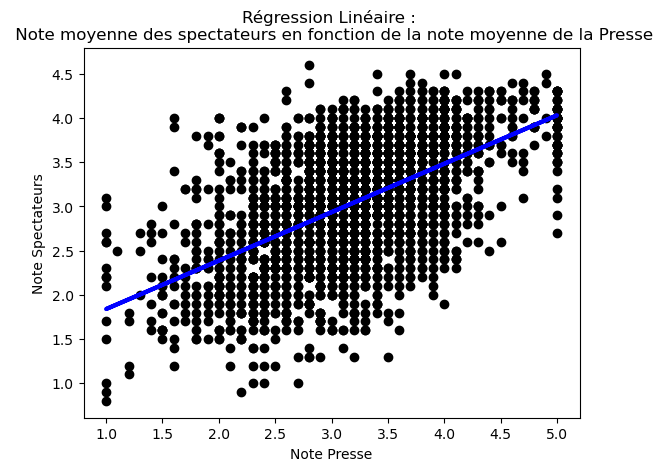

In [22]:
# Sélection des variables pour la régression. 
X = df[['note_Presse']]
y = df['note_Spectateurs']

# Diviser les données en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputer pour remplacer les NaN par la moyenne dans les données d'entraînement et de test
imputer_X = SimpleImputer(strategy='mean')
X_train_imputed = imputer_X.fit_transform(X_train)
X_test_imputed = imputer_X.transform(X_test)

# Ajout d'une constante 
X_train_imputed = sm.add_constant(X_train_imputed)

# Génération du modèle de régression linéaire 
model = sm.OLS(y_train, X_train_imputed).fit()

# Afficher les résultats 
print(model.summary())

# Effectuer des prédictions sur les données de test
X_test_imputed = sm.add_constant(X_test_imputed)
predictions = model.predict(X_test_imputed)

# Évaluer la performance du modèle
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error : {mse}')
print(f'R-squared : {r2}')

# Tracer la régression linéaire
plt.scatter(X_test, y_test, color='black')  #Représentation graphique 
plt.plot(X_test, predictions, color='blue', linewidth=3)
plt.xlabel('Note Presse')
plt.ylabel('Note Spectateurs')
plt.title('Régression Linéaire : \n Note moyenne des spectateurs en fonction de la note moyenne de la Presse')
plt.show()

In [11]:
# Sélectionner des variables 
X = df[['Récompense']]
y = df['note_Presse']

# Diviser les données en deux sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Traitement des NaN 
imputer_X = SimpleImputer(strategy='mean')
X_train_imputed = imputer_X.fit_transform(X_train)
X_test_imputed = imputer_X.transform(X_test)

# Ajout Cosntante 
X_train_imputed = sm.add_constant(X_train_imputed)

# Génération du modèle 
model = sm.OLS(y_train, X_train_imputed).fit()

# Afficher le résumé du modèle
print(model.summary())

# Effectuer des prédictions sur les données de test
X_test_imputed = sm.add_constant(X_test_imputed)
predictions = model.predict(X_test_imputed)

# Évaluer la performance du modèle
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error : {mse}')
print(f'R-squared : {r2}')

                            OLS Regression Results                            
Dep. Variable:            note_Presse   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7169
Date:                Mon, 11 Dec 2023   Prob (F-statistic):              0.397
Time:                        17:39:58   Log-Likelihood:                -10994.
No. Observations:               10117   AIC:                         2.199e+04
Df Residuals:                   10115   BIC:                         2.201e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1935      0.008    413.343      0.0

## Contrôle par Budget ##

In [19]:
#Conversion pour conserver seulement les films dont un connait le budget
# Adaptation des données par remplacement de caractères 
df_bud = df.copy()
df_bud['Budget'] = df['Budget'].replace(['\$', ',', ' '], ['', '', ''], regex=True)

# Convertir les valeurs en floats
df_bud['Budget'] = pd.to_numeric(df_bud['Budget'], errors='coerce')

# Supprimer les lignes ayant des NaN au budget pour computer la régression 
df_bud = df_bud.dropna(subset=['Budget'])
df_bud

,url,id,note_Presse,note_Spectateurs,Année de production,Distributeur,Budget,Langues,Récompense,Category_note_Presse,Category_note_Spectateurs
65,https://www.allocine.fr/film/fichefilm_gen_cfi...,5818,4.9,4.3,1997.0,The Walt Disney Company France,200000000.0,Anglais,0,5,4
66,https://www.allocine.fr/film/fichefilm_gen_cfi...,111431,4.1,3.4,2006.0,The Jokers / Les Bookmakers,11000000.0,"Coréen, Anglais",0,4,3
77,https://www.allocine.fr/film/fichefilm_gen_cfi...,221387,2.9,3.7,2014.0,Metropolitan FilmExport,20000000.0,"Anglais, Russe",0,3,4
79,https://www.allocine.fr/film/fichefilm_gen_cfi...,13085,4.4,4.1,1998.0,Ciné Sorbonne,52000000.0,"Anglais, Japonais",0,4,4
114,https://www.allocine.fr/film/fichefilm_gen_cfi...,222968,3.6,4.1,2015.0,Warner Bros. France,35000000.0,Anglais,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...
33731,https://www.allocine.fr/film/fichefilm_gen_cfi...,56068,3.2,3.3,2004.0,Tecumseh.works,107956.0,Français,0,3,3
33973,https://www.allocine.fr/film/fichefilm_gen_cfi...,201914,3.6,3.4,2012.0,ASC Distribution,1000000.0,"Arabe, Hebreu",0,4,3
34053,https://www.allocine.fr/film/fichefilm_gen_cfi...,108649,3.7,2.7,2004.0,Les Films du Paradoxe,38113.0,Italien,0,4,3
39589,https://www.allocine.fr/film/fichefilm_gen_cfi...,8297,3.0,2.5,1998.0,-,15000000.0,Anglais,0,3,3


In [22]:
# Sélection des variables 
X = df_bud[['Budget']]
y = df_bud['note_Presse']

# Training et test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputer pour remplacer les NaN par la moyenne dans les données d'entraînement et de test
imputer_X = SimpleImputer(strategy='mean')
X_train_imputed = imputer_X.fit_transform(X_train)
X_test_imputed = imputer_X.transform(X_test)

# Ajout Constante 
X_train_imputed = sm.add_constant(X_train_imputed)

# Créer un modèle de régression linéaire
model = sm.OLS(y_train, X_train_imputed).fit()

# Afficher le résumé du modèle
print(model.summary())

# Prédiction 
X_test_imputed = sm.add_constant(X_test_imputed)
predictions = model.predict(X_test_imputed)

# Évaluer la performance 
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error : {mse}')
print(f'R-squared : {r2}')

                            OLS Regression Results                            
Dep. Variable:            note_Presse   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8837
Date:                Mon, 11 Dec 2023   Prob (F-statistic):              0.347
Time:                        17:51:19   Log-Likelihood:                -2360.3
No. Observations:                1925   AIC:                             4725.
Df Residuals:                    1923   BIC:                             4736.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1254      0.019    165.967      0.0

## Contrôle par le Box Office ##

In [26]:
#Préparation de base de données pour le box office 
df_office = df.copy() 
df_office = df.dropna(subset=['Box Office France'])
df_office['Box Office France'] = df_office['Box Office France'].replace(['entrées', ' '], ['', ''], regex=True)
df_office['Box Office France'] = df_office['Box Office France'].astype(float)
df_office

/tmp/ipykernel_262/3786348553.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_office['Box Office France'] = df_office['Box Office France'].replace(['entrées', ' '], ['', ''], regex=True)
/tmp/ipykernel_262/3786348553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_office['Box Office France'] = df_office['Box Office France'].astype(float)


,url,id,note_Presse,note_Spectateurs,Box Office France,Année de production,Distributeur,Budget,Langues,Récompense
0,https://www.allocine.fr/film/fichefilm_gen_cfi...,304685,4.0,3.9,879339.0,2023.0,Gaumont Distribution,-,Français,0
1,https://www.allocine.fr/film/fichefilm_gen_cfi...,255726,4.9,4.3,866227.0,2022.0,Universal Pictures International France,-,Anglais,0
2,https://www.allocine.fr/film/fichefilm_gen_cfi...,287538,3.5,3.9,394717.0,2023.0,SND,-,Français,0
3,https://www.allocine.fr/film/fichefilm_gen_cfi...,277129,2.7,3.7,2122973.0,2023.0,Warner Bros. France,-,Anglais,0
4,https://www.allocine.fr/film/fichefilm_gen_cfi...,289056,3.2,4.1,161254.0,2022.0,ARP Sélection,-,Anglais,0
...,...,...,...,...,...,...,...,...,...,...
35865,https://www.allocine.fr/film/fichefilm_gen_cfi...,228860,3.2,3.6,114.0,2012.0,Damned Distribution,-,Russe,0
39445,https://www.allocine.fr/film/fichefilm_gen_cfi...,26287,3.3,3.7,33632.0,2000.0,Océan Films,-,Italien,0
39504,https://www.allocine.fr/film/fichefilm_gen_cfi...,34999,3.4,3.2,21123.0,2000.0,-,-,-,0
82332,https://www.allocine.fr/film/fichefilm_gen_cfi...,171715,3.3,2.5,753.0,2009.0,-,-,Turc,0


In [27]:
# Sélectionner les colonnes pour la régression linéaire 
X = df_office[['Box Office France']]
y = df_office['note_Presse']

# Diviser les données en ensembles d'entraînement et de test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Remplacement des NaN 
imputer_X = SimpleImputer(strategy='mean')
X_train_imputed = imputer_X.fit_transform(X_train)
X_test_imputed = imputer_X.transform(X_test)

# Ajouter une colonne de constantes
X_train_imputed = sm.add_constant(X_train_imputed)

# Régression 
model = sm.OLS(y_train, X_train_imputed).fit()

# Afficher le résumé du modèle
print(model.summary())

# Prédire 
X_test_imputed = sm.add_constant(X_test_imputed)
predictions = model.predict(X_test_imputed)

# Évaluer la performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error : {mse}')
print(f'R-squared : {r2}')

                            OLS Regression Results                            
Dep. Variable:            note_Presse   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     59.02
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           1.78e-14
Time:                        10:18:55   Log-Likelihood:                -6672.8
No. Observations:                6803   AIC:                         1.335e+04
Df Residuals:                    6801   BIC:                         1.336e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0623      0.009    359.283      0.0

In [28]:
# Sélectionner les variables 
X = df_office[['Box Office France']]
y = df_office['note_Spectateurs']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputer pour remplacer les NaN par la moyenne 
imputer_X = SimpleImputer(strategy='mean')
X_train_imputed = imputer_X.fit_transform(X_train)
X_test_imputed = imputer_X.transform(X_test)

# Ajouter une colonne de constantes
X_train_imputed = sm.add_constant(X_train_imputed)

# Créer un modèle de régression linéaire
model = sm.OLS(y_train, X_train_imputed).fit()

# Résultats 
print(model.summary())

# Effectuer des prédictions sur les données de test
X_test_imputed = sm.add_constant(X_test_imputed)
predictions = model.predict(X_test_imputed)

# Estimation performance du modèle 
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error : {mse}')
print(f'R-squared : {r2}')

                            OLS Regression Results                            
Dep. Variable:       note_Spectateurs   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     150.0
Date:                Wed, 13 Dec 2023   Prob (F-statistic):           3.90e-34
Time:                        10:19:24   Log-Likelihood:                -7056.3
No. Observations:                6803   AIC:                         1.412e+04
Df Residuals:                    6801   BIC:                         1.413e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9609      0.009    328.351      0.0

In [64]:
# Variables pour la régression avec contrôle 
X = df_office[['note_Presse', 'Box Office France']]
y = df_office['note_Spectateurs']

# Diviser les données en ensembles d'entraînement et de test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Remplacement des NaN 
imputer_X = SimpleImputer(strategy='mean')
X_train_imputed = imputer_X.fit_transform(X_train)
X_test_imputed = imputer_X.transform(X_test)

# Standardiser les variables explicatives
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train_imputed)
X_test_standardized = scaler.transform(X_test_imputed)

# Ajouter une colonne de constantes à X_train_standardized
X_train_standardized = sm.add_constant(X_train_standardized)

# Régression linéaire
model = sm.OLS(y_train, X_train_standardized).fit()

# Afficher les résultats 
print(model.summary())

# Effectuer des prédictions sur les données de test
X_test_standardized = sm.add_constant(X_test_standardized)
predictions = model.predict(X_test_standardized)

# Évaluer la performance 
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error : {mse}')
print(f'R-squared : {r2}')

                            OLS Regression Results                            
Dep. Variable:       note_Spectateurs   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     1530.
Date:                Wed, 13 Dec 2023   Prob (F-statistic):               0.00
Time:                        14:58:29   Log-Likelihood:                -5866.8
No. Observations:                6803   AIC:                         1.174e+04
Df Residuals:                    6800   BIC:                         1.176e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0047      0.007    432.284      0.0

# Analyse des valeurs manquantes #

On va regarder si les caractéristiques des films diffèrent dans leur lanque de diffusion. En effet, il n'y a pas de valeurs manquantes dans cette colonne. Comparer, on va analmyser le nombre de langues disponibles par film. 

In [42]:
movie['Langues'].isnull().sum()

0

On voit que le nombre de valeurs manquantes est nul. Ainsi, on pourra se servir de cette variable. Elle est sous la forme d'une liste de langues. Ainsi, on va compter le nombre de virgules de séparation en ajoutant 1 pour avoir le nombre de langues par film. 

In [44]:
def compter_virgules(col):
    """Compte le nombre de virgules dans une colonne."""
    if isinstance(col, pd.Series):
        return col.str.count(',').sum() + 1
    elif pd.notna(col):
        return col.count(',') + 1
    else:
        return 1

# Application 
movie['nombre_langues'] = movie['Langues'].apply(compter_virgules)

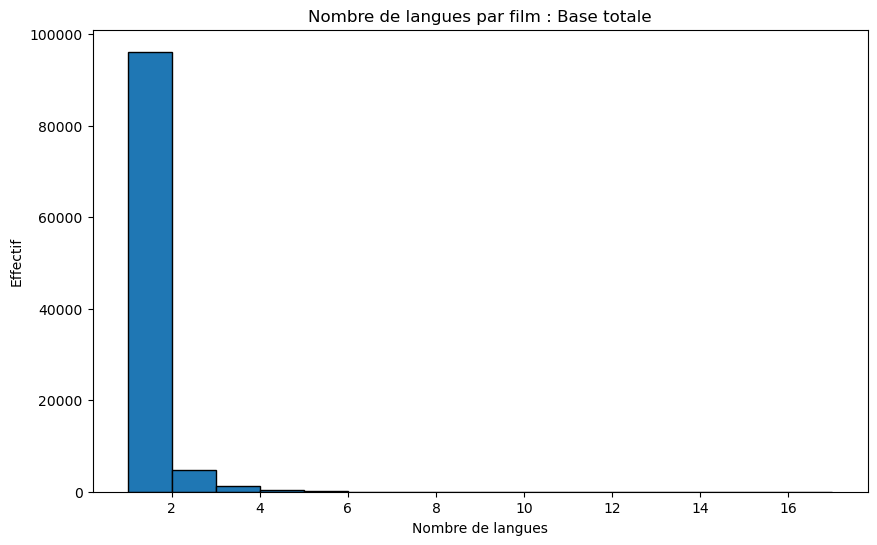

In [58]:
# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(movie['nombre_langues'], bins=range(1, movie['nombre_langues'].max() + 1), edgecolor='black')

# Ajouter des labels et un titre
plt.xlabel('Nombre de langues')
plt.ylabel('Effectif')
plt.title('Nombre de langues par film : Base totale')

#Exportation 
plt.savefig('GraphLanguesTot.png')

# Afficher l'histogramme
plt.show()

In [52]:
movie2 = movie.copy()
# Mêmes ajustement que plus haut
movie2['note_Presse'] = pd.to_numeric(movie2['note_Presse'].replace('--', pd.NA).str.replace(',', '.'), errors='coerce')
movie2['note_Spectateurs'] = pd.to_numeric(movie2['note_Spectateurs'].replace('--', pd.NA).str.replace(',', '.'), errors='coerce')
movie2 = movie2.dropna(subset=['note_Presse', 'note_Spectateurs']) #On vire les NaN pour créer le graphique

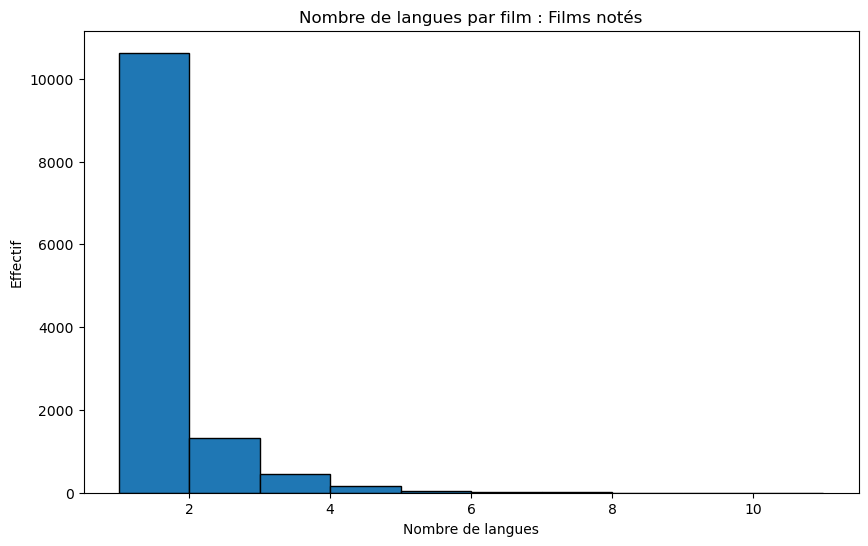

In [59]:
# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(movie2['nombre_langues'], bins=range(1, movie2['nombre_langues'].max() + 1), edgecolor='black')

# Ajouter des labels et un titre
plt.xlabel('Nombre de langues')
plt.ylabel('Effectif')
plt.title('Nombre de langues par film : Films notés')

#Exportation 
plt.savefig('GraphLanguesNot.png')

# Afficher l'histogramme
plt.show()

In [53]:
#On vérifie dans la base réduite du budget la répartition
movie3 = movie2.copy()
movie3['Budget'] = movie3['Budget'].replace(['\$', ',', ' '], ['', '', ''], regex=True)
movie3['Budget'] = pd.to_numeric(movie3['Budget'], errors='coerce')
movie3 = movie3.dropna(subset=['Budget'])

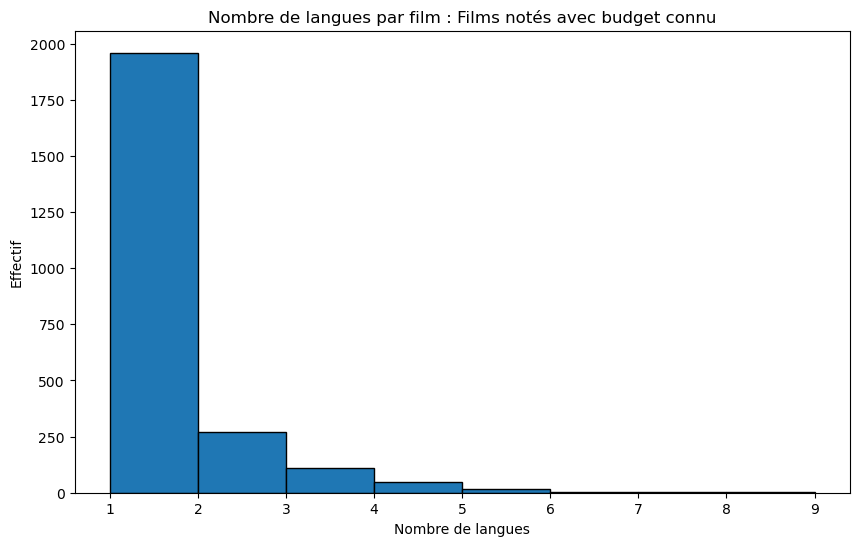

In [60]:
# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(movie3['nombre_langues'], bins=range(1, movie3['nombre_langues'].max() + 1), edgecolor='black')

# Ajouter des labels et un titre
plt.xlabel('Nombre de langues')
plt.ylabel('Effectif')
plt.title('Nombre de langues par film : Films notés avec budget connu')

#Exportation 
plt.savefig('GraphLanguesNotBud.png')

# Afficher l'histogramme
plt.show()

In [55]:
movie4 = movie2.copy()
movie4 = movie4.dropna(subset=['Box Office France'])
movie4['Box Office France'] = movie4['Box Office France'].replace(['entrées', ' '], ['', ''], regex=True)
movie4['Box Office France'] = movie4['Box Office France'].astype(float)

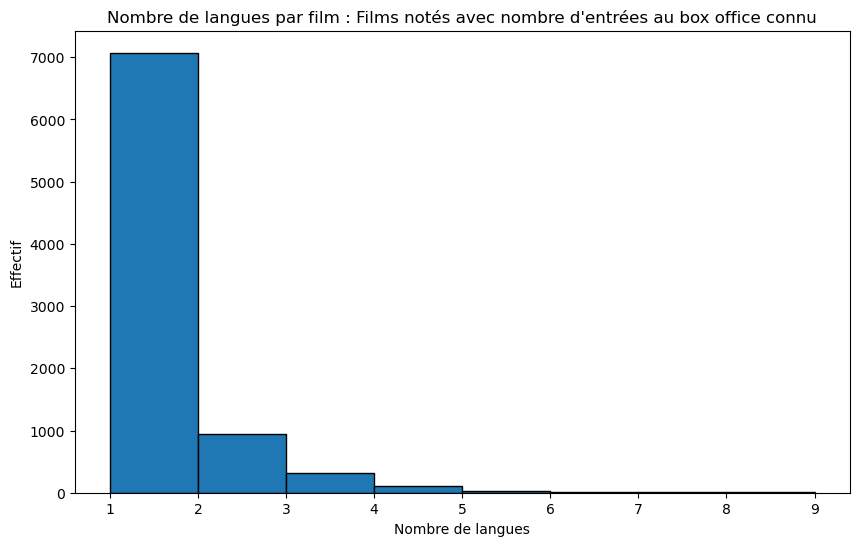

In [61]:
# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(movie4['nombre_langues'], bins=range(1, movie3['nombre_langues'].max() + 1), edgecolor='black')

# Ajouter des labels et un titre
plt.xlabel('Nombre de langues')
plt.ylabel('Effectif')
plt.title("Nombre de langues par film : Films notés avec nombre d'entrées au box office connu")

#Exportation 
plt.savefig('GraphLanguesNotBoxOff.png')

# Afficher l'histogramme
plt.show()